
# Machine Learning Engineer Nanodegree


## Capstone Project

Jürgen Mollen

"Space Shuttle Escape"

### Domain Background (Project Overview)

I would like to examine (and solve) a theme in deep leaning robotics. The idea is to navigate a space shuttle from a source position to a target position (‘docking bay’)
This would be a continuous deep 𝑄 -Learning problem. I would like to adopt what I have learned in 𝑄 –Learning and neural networks to find a solution. To simplify the domain space, the problem shall be in a 2 dimensional world. And the shuttle shall have a varable throttle, and be able to apply it to any direction by rotating along its axis. The angular speed of the rotation shall be limited.

This is only a steering Notebook

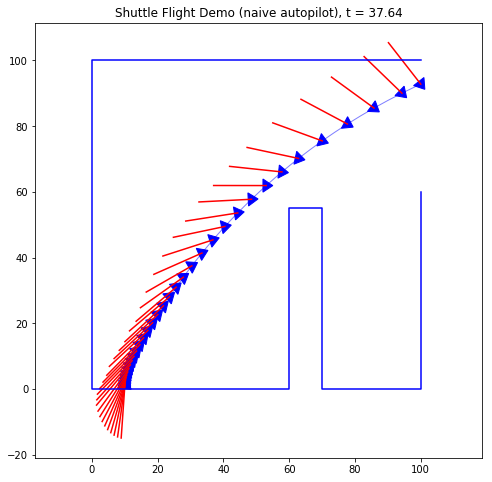

In [11]:
"""
Created on Sun Oct 27 19:09:30 2019

@author: Juergen Mollen (Git:JueMol)


This is a DeepQN robotics problem:

A space shuttle is in a space ship hangar in free space (no gravity).
The goal is to get to the exit ('docking bay') as quick as possible.

The space shuttle has a constant thrust. The space shuttle is able to change it orientation
with a constant angular velocity to its left, right or stay with its orientation.

At t=0 the space shuttle is at the bottom left corner of the hangar and is oriented upwards.

An obstacle ('wall') exists in the mid of the hangar making it impossible to reach the exit 
in the straight direction.

A naive linear autopilot is built in that already give a pretty good solution to the problem.

The goal is to let the shuttle learn via the DQNAgent to find its way by itself and do  
better than the autopilot i.e. to need less time.
"""
#  ... uncomment for Jupyter notebook
%matplotlib inline   

#
# To warm-up: Calculate and plot the solution trajectory by the naive autopilot
#
from Physics.SpaceShuttlePhysics import SpaceShuttlePhysics
envi_demo = SpaceShuttlePhysics(runtime=100.)
envi_demo.do_demo()

In [12]:
import sys
import numpy as np

from DeepQ.DQNAgent import DQNAgent


#
# Some steering constants
#

train_episodes = 2000          # max number of episodes to learn from
max_steps = 1000               # max steps in an episode
batch_size = 64                # experience mini-batch size
decay_rate = 0.997             # experience decay rate 


#
# Create simulation 'envi'
#
envi  = SpaceShuttlePhysics()

#
# Create Deep Q Network agent 'agent'
#
agent = DQNAgent(state_size=envi.state_size(), action_size=envi.action_size(), decay=decay_rate)

#
# In the beginning, make a bunch of actions and store the experiences to initially fill memory ...
#
envi.reset()
envi.ang += 0.1 * np.random.randn()       # smear out
envi.pos[0] += 0.5 * np.random.randn()
state = envi.get_state()
for ii in range(1000):
    # Make an outoilot action
    action = envi.naive_policy_action()
    next_state, reward, done, _ = envi.step(action)
    agent.remember(state, action, reward, next_state, done) 

    if done:
        envi.reset()
        envi.ang += 0.1*np.random.randn()       # smear out
        envi.pos[0] += 0.5*np.random.randn()
        state = envi.get_state()
    else:
        state = next_state
        
        
#
# Do the _real_ learning ...
#
rewards_list = []     # ... used for logging
episode_paths = []
epsode_rewards_r = []
cumulative_steps = []

# Loor over range of episodes
for ep in range(1, train_episodes):

    # Reset the simulation, setting  the shuttle again at its starting place
    envi.reset(ep)
    envi.ang += 0.001 * np.random.randn() #* agent.epsilon # ... do some (decaying) exploration noise to start parameters
    envi.pos[0] += 0.1 * np.random.randn()# * agent.epsilon # ... do some (decaying) exploration noise to start parameters
    state = envi.get_state()
    
    total_reward = 0.
    step = 0

    # Do the steps until done (or max steps reached)
    while step < max_steps:
        
        # Take action, get new state and reward        
        action = agent.act(state)       
        next_state, reward, done, _ = envi.step(action)     
        
        # Remember step
        agent.remember(state, action, reward, next_state, done)    # ... Bellmann equation hidden in agent
        
        # Get next state
        state = next_state

        # Log total reward
        total_reward += reward
        
        # Log a reward along a 2/4 episode
        if ep == train_episodes/4*3:
            epsode_rewards_r.append(max(total_reward, -1000.))
    
        if done:
            # Do Logging and printouts (not part of the learning itself)
            cumulative_steps.append(step)
            rewards_list.append((ep, max(total_reward, -1000.)))
            episode_paths.append(envi.path)
            print('\rEpisode: {}'.format(ep) + 
                  ' Total reward: {:.4f}'.format(total_reward) +
                  ' Explore P: {:.4f}'.format(agent.epsilon) +
                  ' X: {:.4f}'.format(envi.pos[0]) + 
                  ' Y: {:.4f}'.format(envi.pos[1]) + 
                  ' t: {:.2f}'.format(envi.time)
                  , end='', flush=True)
            sys.stdout.flush()         
                    
            break

        else:
            step += 1

    # Do the training (of the Q Funtion) based on experiences
    agent.replay(batch_size)
    


Episode: 1999 Total reward: 16.1282 Explore P: 0.0100 X: 100.0461 Y: 94.2198 t: 40.31843

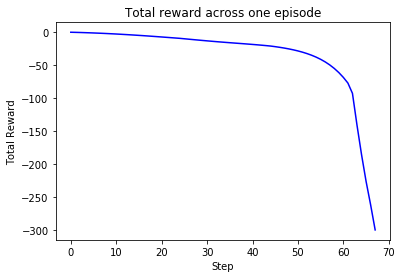

In [13]:
import matplotlib.pyplot as plt

#
# Plot reward across one episode 
#
episode_t = np.arange(len(epsode_rewards_r))
plt.plot(episode_t, epsode_rewards_r, color='blue')
plt.xlabel('Step')
plt.ylabel('Total Reward')
plt.title('Total reward across one episode')
plt.show()


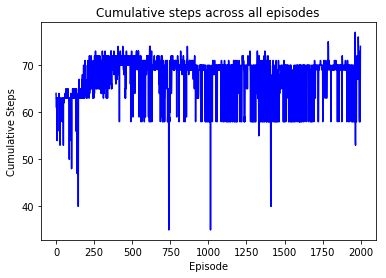

In [14]:
#
# Plot cumulative steps across all episodes
#
x = np.arange(len(cumulative_steps))
plt.plot(x, cumulative_steps, color='blue')
plt.xlabel('Episode')
plt.ylabel('Cumulative Steps')
plt.title('Cumulative steps across all episodes')
plt.show()


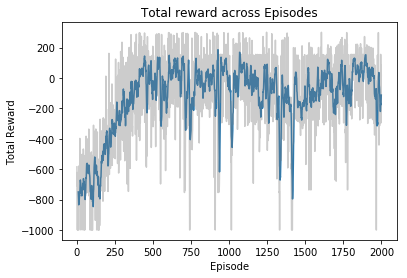

In [15]:
#
# Plot total reward curve over all episodes (rewards and running mean)
#
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.4)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total reward across Episodes')
plt.show()


In [16]:
#
# Plot the best AI trajectory (thats not necessarily the last)
#
path = envi.bestpath
timetot = envi.bestpath.t
episode = envi.bestpath.episode
envi.plot_trajectory('Shuttle Flight Demo (AI), t = {:.2f}'.format(timetot) + ', Eps = {}'.format(episode))


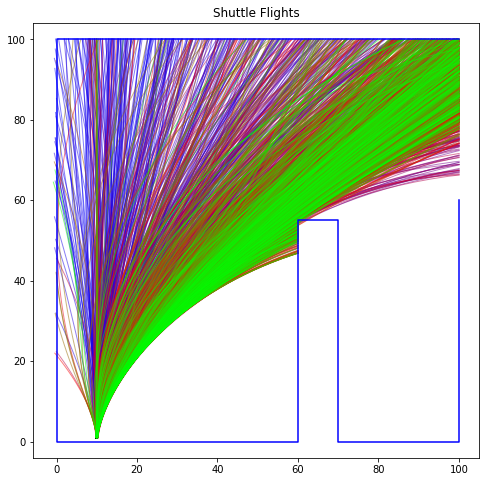

In [17]:
#
# Plot all Trajectories during the whole learning phase
#
envi.plot_trajectory('Shuttle Flights', episode_paths, with_shuttle=False, num_episodes=train_episodes)


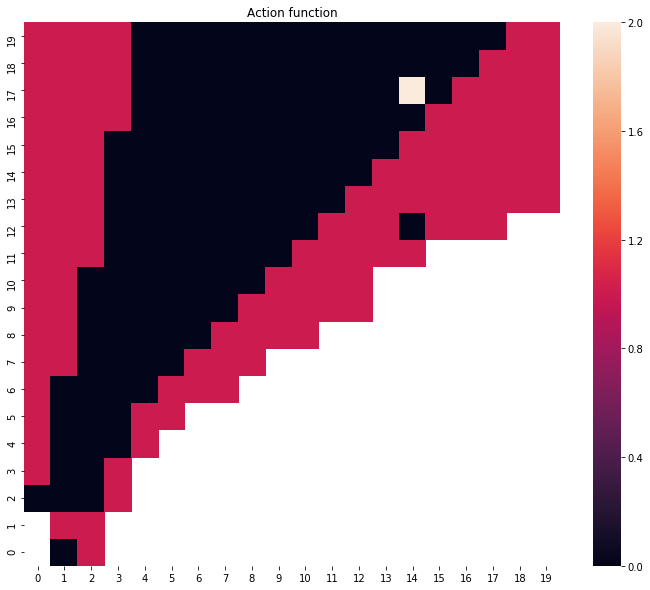

In [18]:
#
# Sneak into the action function 
#

# Since the state space is 5 dimensional and action space 3 dimensional (although one hot encoded - therefore it 
# is in principle one dimensional with three values), I need to do some simplification to be able to visualize.
# The idea is to that -due to the continuous physics of the movement- each rectangle in space has an average 
# velocity vector and an average angle with not too much deviation within.
# Then I can take those average values and ask the neural net of the agent to predict action for those 'averaged 
# state space'.
# The predictions then can have three states:
#   0 = turn more to the right
#   1 = stay with current angle
#   2 = turn to the left
# It is important for me to visualize roughly what the 'machine thinks'  ;-)
# Plot the action function for a 20x20 grid whereas X=20 equals to X=100 in the stape space
#
import seaborn as sns

class xy:
    ''' helper class for averaging '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.vx = 0.
        self.vy = 0.
        self.ang = 0.
        self.count = 0
    def add(self, vx, vy, ang):
        self.vx += vx
        self.vy += vy
        self.ang += ang
        self.count += 1    
    def get_state(self):
        if self.count > 0:
            return np.array([self.x, self.y, self.vx / self.count, self.vy / self.count, self.ang / self.count])
        else:
            return np.zeros(5)

xy_arr = []
for ix in range (20):
    y = []
    xy_arr.append(y)
    for iy in range(20):
        xy_el = xy(5.*ix+2.5, 5.*iy+2.5)
        y.append(xy_el)

for trajectory in episode_paths:
    posx, posy, velx, vely, accx, accy, angl, t = trajectory.gettrajectory()
    for x, y, vx, vy, ax, ay, ang  in zip(posx, posy, velx, vely, accx, accy, angl):
        ix = int(x/5.)
        iy = int(y/5.)
        if (ix < 20 and iy < 20):
            xy_arr[ix][iy].add(vx, vy, ang)
        
actions = np.zeros([20, 20])
mask = np.zeros([20, 20])
for ix in range(20):
    for iy in range(20):
        xy_bin = xy_arr[ix][iy]
        if xy_bin.count > 0:
            state = xy_bin.get_state()
            state = np.reshape(state, [1, envi.state_size()])
            #print(state)
            actions[iy, ix] = agent.act(state)
        else :
            mask[iy,ix] = None  # to denote empty cells
            
plt.figure(figsize=(12,10))
ax = sns.heatmap(actions, mask=mask, vmax=2)
ax.invert_yaxis()
ax.set_title('Action function')
plt.show()


In [19]:
#
# Plot the best AI trajectory (thats not necessarily the last)
#
path = envi.bestpath
timetot = envi.bestpath.t
episode = envi.bestpath.episode
envi.plot_trajectory('Shuttle Flight Demo (AI), t = {:.2f}'.format(timetot) + ', Eps = {}'.format(episode))
